# Exploratory Data Analysis - Rank

## Imports

In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from src import load_observations_csv, load_names_csv
from src.utils import get_id2preferred_id, get_names_pref_df

In [3]:
observations_df, names_df = load_observations_csv(), load_names_csv()

## Names

In [4]:
name2unique_count_df = names_df.groupby("synonym_id")["id"].nunique().reset_index(name="unique_count").sort_values("unique_count", ascending=False)
name2unique_count_df.synonym_id = name2unique_count_df.synonym_id.astype("string")
display(name2unique_count_df)
mask1 = (names_df.synonym_id.isna()) & (names_df.deprecated == 0)
mask2 = (names_df.synonym_id.isna()) & (names_df.deprecated == 0) & (names_df.correct_spelling_id.isna())
print(f'Names without a synonym ID and that are not deprecated: {len(names_df[mask1])}')
print(f'Names without a synonym ID, correct spelling ID, and that are not deprecated: {len(names_df[mask2])}')
print(f'Total # of names: {len(names_df[mask1]) + len(name2unique_count_df)}.')

,synonym_id,unique_count
4302,4950.0,92
2557,2884.0,59
4928,5655.0,57
2277,2523.0,55
4048,4664.0,52
...,...,...
5669,6485.0,1
6843,8396.0,1
6842,8369.0,1
4014,4627.0,1


Names without a synonym ID and that are not deprecated: 44078
Names without a synonym ID, correct spelling ID, and that are not deprecated: 44078
Total # of names: 52168.


**Conclusion**
- No non-deprecated name without synonym ID with spelling ID.

In [5]:
name2unique_count_df.head(10)

,synonym_id,unique_count
4302,4950.0,92
2557,2884.0,59
4928,5655.0,57
2277,2523.0,55
4048,4664.0,52
4491,5160.0,47
5096,5848.0,46
3159,3614.0,42
7805,9696.0,40
21,30.0,34


<AxesSubplot:xlabel='unique_count', ylabel='synonym_id'>

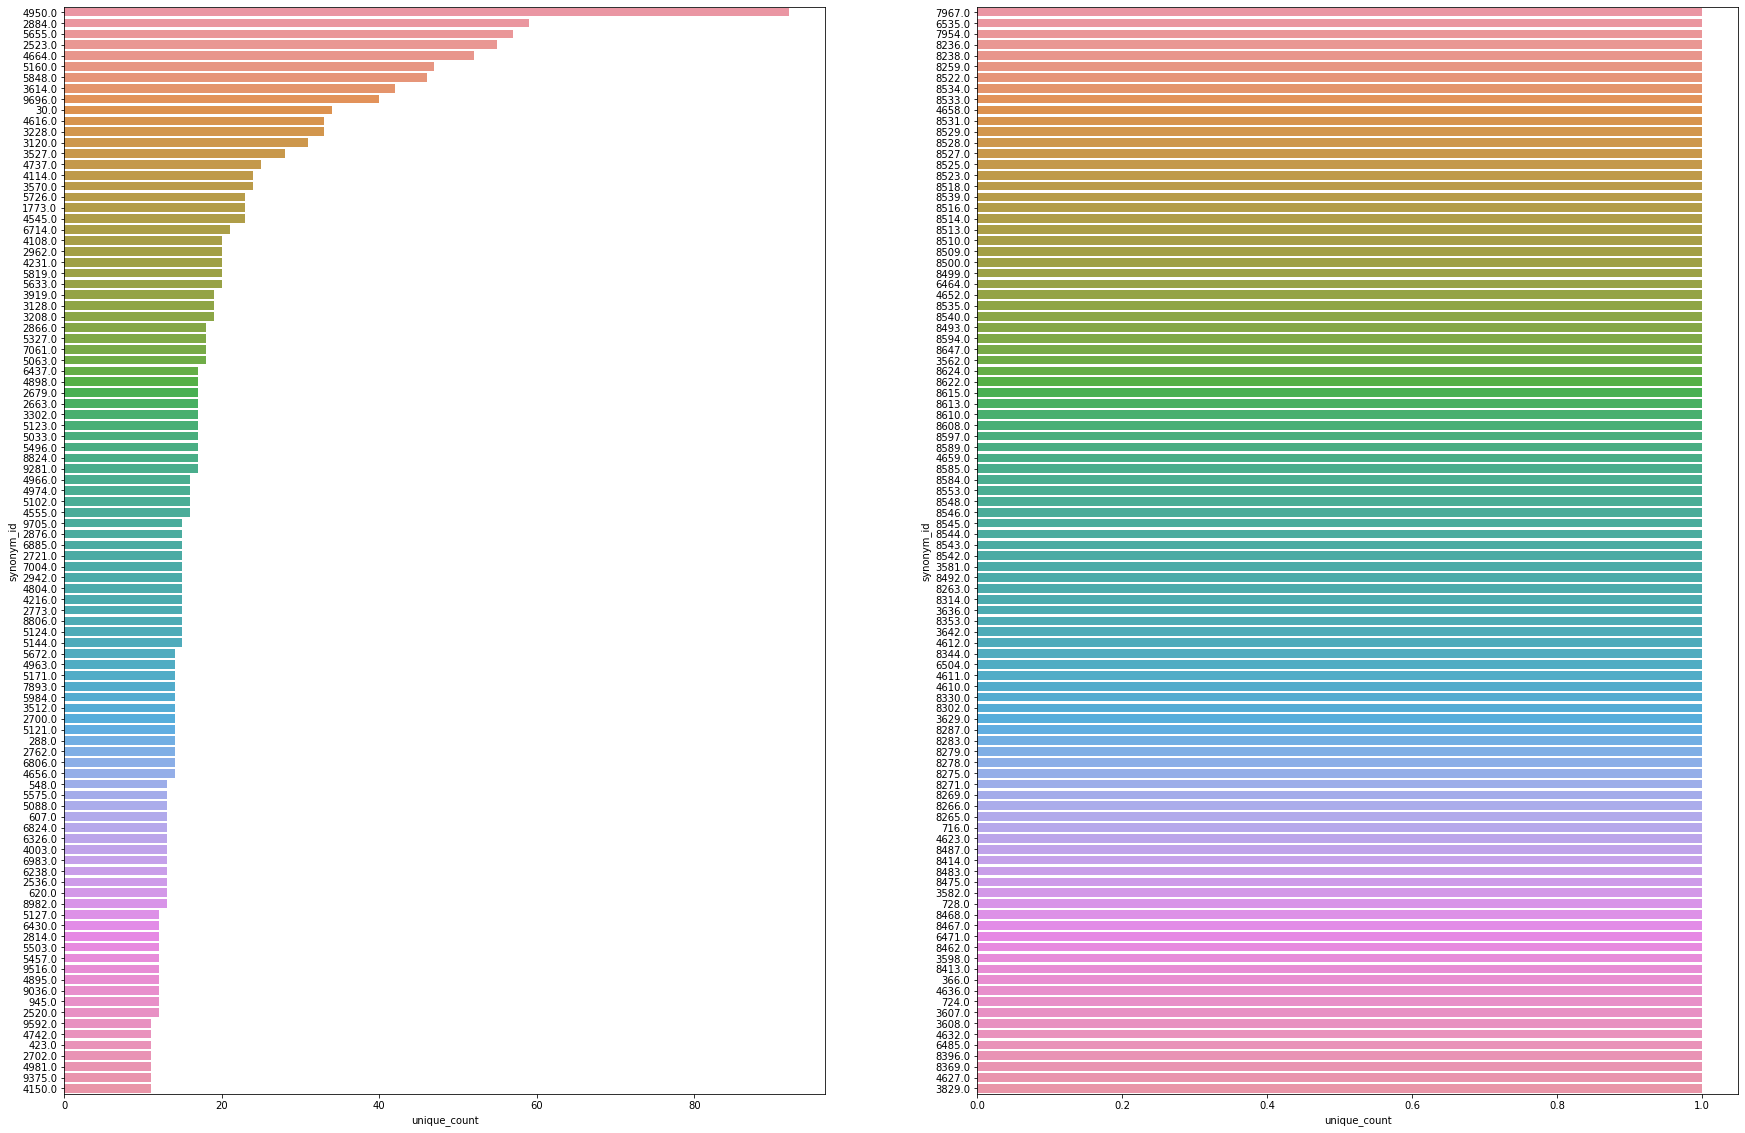

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(30, 20))
sns.barplot(data=name2unique_count_df.head(100), y="synonym_id", x='unique_count', orient="h", ax=ax[0])
sns.barplot(data=name2unique_count_df.tail(100), y="synonym_id", x='unique_count', orient="h", ax=ax[1])

In [7]:
mask = name2unique_count_df.unique_count == 1
print(f'There are {len(name2unique_count_df[mask])} names with synonym IDs but no counterpart.')

There are 1120 names with synonym IDs but no counterpart.


### Deprecated IDs
Do deprecated IDs map to non-deprecated ones?

In [8]:
mask = names_df.deprecated == 1
names_df[mask]

,id,text_name,author,deprecated,correct_spelling_id,synonym_id,rank
5,6,Xerocomus zelleri,(Murrill) Snell,1,NaN,505.0,4
7,8,Xerocomus dryophilus,(Thiers) Singer,1,NaN,4404.0,4
8,9,Xerocomus chrysenteron,(Bull.) Quél.,1,NaN,9724.0,4
9,10,Volvariella gloiocephala,(DC.) Boekhout & Enderle,1,NaN,593.0,4
20,22,Tylopilus eximius,(Peck) Singer,1,NaN,6094.0,4
...,...,...,...,...,...,...,...
66109,112039,Cantharellus tabaeformis,NaN,1,6305.0,5573.0,4
66127,112059,Panaeolus sphinctrinum,NaN,1,721.0,290.0,4
66136,112069,Gymnopus junonius,NaN,1,2412.0,6034.0,4
66137,112070,Ostinea,NaN,1,510.0,288.0,9


In [15]:
synonym_id = 290
mask = names_df.synonym_id == synonym_id
names_df[mask]

,id,text_name,author,deprecated,correct_spelling_id,synonym_id,rank
435,470,Panaeolus papilionaceus,(Bull.) Quél.,0,NaN,290.0,4
666,721,Panaeolus sphinctrinus,(Fr.) Quél.,1,NaN,290.0,4
930,1004,Panaeolus papilionaceus var. parvisporus,Ew. Gerhardt,0,NaN,290.0,2
3090,3288,Panaeolus campanulatus,(L.) Quél.,1,NaN,290.0,4
4618,4868,Panaeolus callosus,NaN,1,NaN,290.0,4
5112,5473,Paneolus campanulatus,NaN,1,3288.0,290.0,4
14437,14969,Panaeolus papilionaceus var. papilionaceus,(Bull.) Quél.,0,NaN,290.0,2
44934,50166,Copelandia papilionaceus,NaN,1,470.0,290.0,4
64886,110678,Panaelous papilionaceus,NaN,1,470.0,290.0,4
66127,112059,Panaeolus sphinctrinum,NaN,1,721.0,290.0,4


**Observations**
- Deprecated names seem to often be mapped to non-deprecated synonyms.
- Synonyms may involve different ranks!

### Preferred name IDs:
- Map name IDs to the smallest, non-deprecated name ID within a synonym group if existent.
- Keep original name ID otherwise.

In [35]:
id2preferred_id = get_id2preferred_id(names_df=names_df)

In [42]:
names_pref_df = names_df.copy()
names_pref_df["preferred_id"] = names_df["id"].map(lambda id_: id2preferred_id.get(id_, id_))
names_pref_df.iloc[930]

id                                                         1004
text_name              Panaeolus papilionaceus var. parvisporus
author                                             Ew. Gerhardt
deprecated                                                    0
correct_spelling_id                                         NaN
synonym_id                                                290.0
rank                                                          2
preferred_id                                              470.0
Name: 930, dtype: object

In [43]:
names_pref_df.tail()

,id,text_name,author,deprecated,correct_spelling_id,synonym_id,rank,preferred_id
66148,112081,Phlebiodontia subochracea,NaN,0,NaN,NaN,4,112081.0
66149,112082,Hebeloma citrisporum,Beker & U. Eberh.,0,NaN,NaN,4,112082.0
66150,112083,Hygrocybe glacialis,T.Borgen & Senn-Irlet,0,NaN,NaN,4,112083.0
66151,112084,Sertulicium niveocremeum,NaN,0,NaN,NaN,4,112084.0
66152,112085,Tephrocybella,NaN,0,NaN,NaN,9,112085.0


In [44]:
names_pref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66153 entries, 0 to 66152
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   66153 non-null  int64  
 1   text_name            66153 non-null  object 
 2   author               47550 non-null  object 
 3   deprecated           66153 non-null  int64  
 4   correct_spelling_id  1591 non-null   float64
 5   synonym_id           21777 non-null  float64
 6   rank                 66153 non-null  int64  
 7   preferred_id         65622 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 4.0+ MB


In [45]:
mask = names_pref_df.preferred_id.isna()
names_pref_df[mask]

,id,text_name,author,deprecated,correct_spelling_id,synonym_id,rank,preferred_id
139,154,Morchella elata,Fr.,1,NaN,9990.0,4,NaN
235,256,Gomphus bonari,NaN,1,NaN,4123.0,4,NaN
281,303,Conocybe filaris,(Fr.) Kühner,1,NaN,609.0,4,NaN
590,638,Pseudocyphelaria anomala,NaN,1,6172.0,693.0,4,NaN
988,1066,"Boletus ""rexvernus""",NaN,1,NaN,493.0,4,NaN
...,...,...,...,...,...,...,...,...
62953,108111,Amanitina alliodora,(Pat.) E.-J. Gilbert,1,NaN,8796.0,4,NaN
62996,108193,Polyporus reticulatosporus,Van der Byl,1,NaN,8822.0,4,NaN
63233,108636,Uredo vacciniorum,(DC.) Rabenh.,1,NaN,8860.0,4,NaN
63796,109392,Columellomycetidae,"Leontyev, Schnittler, S.L. Stephenson, Novozh....",1,NaN,9887.0,11,NaN


In [46]:
mask = names_df.synonym_id == 9990
names_df[mask]

,id,text_name,author,deprecated,correct_spelling_id,synonym_id,rank
139,154,Morchella elata,Fr.,1,NaN,9990.0,4
27107,30722,Morchella costata,(Vent.) Pers.,1,NaN,9990.0,4
39033,43442,Morchella elata,Fr. sensu Clowez,1,NaN,9990.0,4


**Observations**
- There are synonym groups that do not have a non-deprecated member.

In [47]:
mask = names_pref_df.preferred_id.isna()
print(f"There are {len(names_pref_df[mask])} names without a non-deprecated name in their synonym group.")

There are 531 names without a non-deprecated name in their synonym group.


**Observations**
- 

In [30]:
observations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468974 entries, 0 to 468973
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      468974 non-null  int64  
 1   name_id                 468974 non-null  int64  
 2   when                    468974 non-null  object 
 3   location_id             468973 non-null  float64
 4   lat                     107615 non-null  float64
 5   long                    107615 non-null  float64
 6   alt                     104447 non-null  float64
 7   vote_cache              465082 non-null  float64
 8   is_collection_location  468974 non-null  int64  
 9   thumb_image_id          450576 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 35.8+ MB


In [57]:
names_pref_df = get_names_pref_df(names_df=names_df)

observations_ranks_df = pd.merge(
    left=observations_df[["id", "name_id"]],
    right=names_pref_df[["id", "preferred_id", "rank"]],
    how="left",
    left_on="name_id",
    right_on="id",
    suffixes=("_obs", "_name")
)

In [58]:
observations_ranks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469249 entries, 0 to 469248
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id_obs        469249 non-null  int64
 1   name_id       469249 non-null  int64
 2   id_name       469249 non-null  int64
 3   preferred_id  469249 non-null  int64
 4   rank          469249 non-null  int64
dtypes: int64(5)
memory usage: 21.5 MB


**Observations**
- All observations get mapped to names.
- ~6% deprecated names.

## Rank Stats

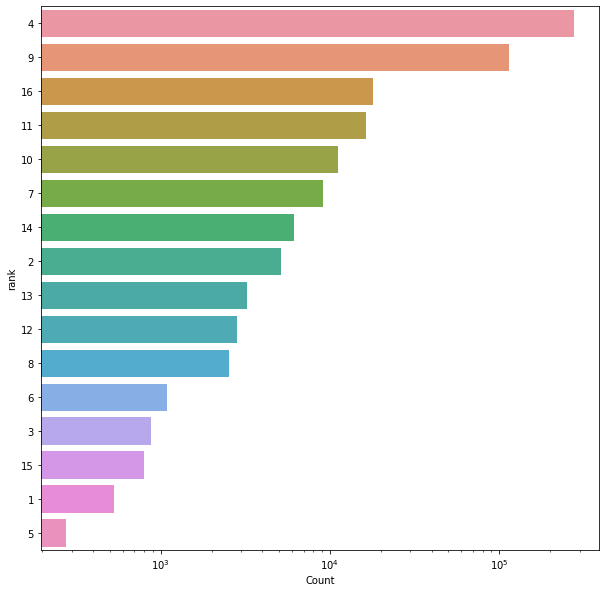

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
to_plot_df = observations_ranks_df.groupby("rank").size().reset_index(name="Count").sort_values("Count", ascending=False)
to_plot_df["rank"] = to_plot_df["rank"].astype(str)
sns.barplot(data=to_plot_df, y="rank", x="Count", ax=ax)
ax.set_xscale("log")

**Observations**
- Most represented ranks, 4 and 9, have ~100,000 observations.

In [61]:
n = 10
for rank in range(1, 15):
    print(f"Rank {rank}:")
    rank_observations_df = get_observations4rank_df(observations_df=observations_df, names_df=names_df, rank=rank)
    to_plot_df = rank_observations_df.groupby("label").size().reset_index(name="Count").sort_values(
        "Count", ascending=False)
    to_plot_df["label"] = to_plot_df.label.astype(str)
    mask = to_plot_df.Count >= n
    print(f"There are {len(to_plot_df[mask])} names with more than {n} observations. This is {len(to_plot_df[mask]) / len(to_plot_df) * 100:.2f}% of the total.")

Rank 1:
There are 5 names with more than 10 observations. This is 4.63% of the total.
Rank 2:
There are 81 names with more than 10 observations. This is 17.09% of the total.
Rank 3:
There are 8 names with more than 10 observations. This is 15.09% of the total.
Rank 4:
There are 3469 names with more than 10 observations. This is 27.87% of the total.
Rank 5:
There are 3 names with more than 10 observations. This is 15.00% of the total.
Rank 6:
There are 14 names with more than 10 observations. This is 23.73% of the total.
Rank 7:
There are 71 names with more than 10 observations. This is 33.81% of the total.
Rank 8:
There are 31 names with more than 10 observations. This is 40.26% of the total.
Rank 9:
There are 562 names with more than 10 observations. This is 41.05% of the total.
Rank 10:
There are 77 names with more than 10 observations. This is 41.18% of the total.
Rank 11:
There are 20 names with more than 10 observations. This is 40.00% of the total.
Rank 12:
There are 9 names with

**Discussion Regarding Labels**

There are two possible definitions of labels:
1. Cross-ranking definition: Map all IDs to one ID from their synonym group if existent, to itself otherwise.
2. Same as 1. but limiting to a certain rank from the beginning on.

Option 1 will produce more labels and allow for a rank-free confusion matrix. Option 2 may be more precise because it removes naming redundancy.